# Лабораторная работа №2.3.3

## Измерение осмотического давления

## Подлкючение библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import math

from scipy.optimize import curve_fit

In [2]:
def Line(x, a, b):
    """
    Параметрическая прямая
    """
    return a*x + b

#-----------------------------------------------------------------------------------------------------------
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! ВНИМАНИЕ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
# Тупой питон не может подставить знак минус перед коэффициентом b! Если экспонента имеет вид e(^b), b < 0,
# то минус надо указать вручную.
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#-----------------------------------------------------------------------------------------------------------
def Exponent(x, a, b, c):
    """
    Параметрическая експонента (ae^(bx)
    """
    return a * np.exp(-b * x) + c

def CalcErrors(popt, cov, precA = 4, precB = 4, printRes = True):
    """
    Вычисляет погрешность МНК.
    Выводит в консоль значения + погрешность.
    Возвращает массив погрешностей.
    """
    errors = []
    for i in range(len(popt)):
        try:
          errors.append(np.absolute(cov[i][i])**0.5)
        except:
          errors.append( 0.00 )
    errors = np.array(errors)

    if (printRes == True):
        print("a = {:.0{prec}f} sig_a = {:.0{prec}f}".format(popt[0], errors[0], prec = precA))
        print("b = {:.0{prec}f} sig_b = {:.0{prec}f}".format(popt[1], errors[1], prec = precB), '\n')

    return errors

def NpToStrList(np_array, precision):
    np_array = np.around(np_array.astype(float), precision)

    return ["{:.0{prec}f}".format(val, prec = precision) for val in np_array]

def NpToStr(array):
    return [str(f) for f in array]

def PrintMinMax(array, header):
    print(header + "min = {:.3f}, max = {:.3f}".format(min(array), max(array)))

In [3]:
def _getIndex(indexRow, indexColumn, isRowDataSet):
    """
    Возвращает индексы в правильном порядке для обращения к массиву.
    """
    if (isRowDataSet == True):
        return (indexRow, indexColumn)
    else:
        return (indexColumn, indexRow)

def _drawRowGrid(file, rowGrid, rowIndex):
    if (rowGrid != None and rowGrid[rowIndex] > 0):
         file.write("\\hline\n" * rowGrid[rowIndex])

def _getTableDim(data, isRowDataSet):
    if (isRowDataSet == True):
        return (len(data), len(data[0]))
    else:
        return (len(data[0]), len(data))

def _createTable(fileName, data, isRowDataSet, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу, если rowDataSet == false и горизонтальную, если rowDataSet == true.

    Аргументы:
    fileName     - имя выходного файла с таблицей;
    data         - массив данных таблицы;
    isRowDataSet - если true, массив данных содержит горизонтальную таблицу, иначе вертикальную;
    columnGrid   - строка, которая определяет тип сетки между колонками: \begin{tabular}{columnGrid};
    rowGrid      - список длины rowCount + 1, в котором содержится число:
                        - 0 - нет       горизонтальной линии;
                        - 1 - одинарная горизонтальная линия;
                        - 2 - двойная   горизонтальная линия.
    """
    rowCount, columnCount = _getTableDim(data, isRowDataSet)

    with open("tables\\" + fileName, 'w', encoding='utf-8') as file:

        if (columnGrid == None):
            columnGrid = "|" + 'c|' * columnCount
        
        file.write("\\begin{tabular}[t]{" + columnGrid +"}\n")

        _drawRowGrid(file, rowGrid, 0)
        
        if (preheader != None):
            file.write(preheader)

        for rowIndex in range(0, rowCount):

            for colIndex in range(0, columnCount - 1):
                index1, index2 = _getIndex(rowIndex, colIndex, isRowDataSet)

                file.write("{} & ".format(str(data[index1][index2]).replace('.', ',')))

            index1, index2 = _getIndex(rowIndex, columnCount - 1, isRowDataSet)

            file.write("{} \\\\ \n".format(str(data[index1][index2]).replace('.', ',')))

            _drawRowGrid(file, rowGrid, rowIndex + 1)

        # End data draw cycle
        file.write('\end{tabular}')

def CreateVerticalTable(fileName, data, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, data, False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateVerticalTableHeader(fileName, header, dataColumns, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт вертикальную Latex-таблицу.
    """
    _createTable(fileName, [[header[st]] + dataColumns[st] for st in range(0, len(dataColumns))],
                                False, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

def CreateHorizontalTable(fileName, dataRows, 
                 columnGrid = None, rowGrid = None, preheader = None):
    """
    Создаёт горизонтальную Latex-таблицу.
    """
    _createTable(fileName, dataRows, True, columnGrid = columnGrid, rowGrid = rowGrid, preheader = preheader)

## Данные

In [4]:
sig_t = 1
sig_h = 0.5

sig_P = 1

k = 1.38 * 10**-23

T = 298

V = 150 * 10**-6
ro_water = 1000
m = ro_water * V

mu_salt = 4 * 39 + 56 + 6 * (12 + 14)
mu_dissolved = 56 + 6 * (12 + 14)

mu_salt /= 1000
mu_dissolved /= 1000

NA = 6.02 * 10**23

P_conv = 245#98066.5 / 400

In [6]:
print(P_conv)

245


In [5]:
sheet_names = ["0,3%", "0,15%", "0,075%"]
h_t_count   = [8, 7, 4]

data = pd.read_excel('data/data 2.3.3 09.06.ods',
                     engine = "odf",
                     header = None,
                     index_col = None,
                     sheet_name = sheet_names,
                     usecols = "A:BM")

n = np.array([0.003, 0.0015, 0.00075])

E:\Python\Anaconda\lib\site-packages\pandas\io\excel\_base.py:1272: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  return self._reader.parse(


In [6]:
class Exp:
    
    def __init__(self, n, data, h_t_count):
        self.n = n
        self.h = []
        self.t = []
        
        self.P = []
        self.v = []
                
        self.popt_h_t = []
        self.pcov_h_t = []
        self.err_h_t  = []
                
        for i in range(0, h_t_count):
            p = data[0 + 6 * i][2  ]
            h = data[4 + 6 * i][2 : 11]
            t = data[3 + 6 * i][2 : 11]
            
            h = np.array(h).astype(float)
            t = np.array(t).astype(float)
            
            h = h[~np.isnan(h)]
            t = t[~np.isnan(t)]
                        
            self.P.append(p)
            self.h.append(h)
            self.t.append(t)
            
            popt_h_t, pcov_h_t = curve_fit(Line, t, h)
            
            self.popt_h_t.append(popt_h_t)
            self.pcov_h_t.append(pcov_h_t)
            
            self.err_h_t.append(CalcErrors(popt_h_t, pcov_h_t, printRes = False))
            
            v = popt_h_t[0]
            
            self.v.append(v)
            
        self.v = np.array(self.v).astype(float)
        self.P = np.array(self.P).astype(float)
        
        if (n == 0.003):
            self.popt_v_p, self.pcov_v_p = curve_fit(Line, self.P[2:len(self.P)], self.v[2:len(self.P)])
            
            self.popt_p_v, self.pcov_p_v = curve_fit(Line, self.v[2:len(self.P)], self.P[2:len(self.P)])
            
            self.sig_all_v = [0.003] + [0.01] * (len(self.P) - 1)
            
        elif (n == 0.0015):
            select = [0, 1,2,3, 4, 5]+[i for i in range(6, len(self.P))]
            self.popt_v_p, self.pcov_v_p = curve_fit(Line, self.P[select], self.v[select])
            
            self.popt_p_v, self.pcov_p_v = curve_fit(Line, self.v[select], self.P[select])
            
            self.sig_all_v = [0.003] + [0.01] * (len(self.P) - 1)
            
        elif (n == 0.00075):
            self.popt_v_p, self.pcov_v_p = curve_fit(Line, self.P[1:], self.v[1:])
            
            self.popt_p_v, self.pcov_p_v = curve_fit(Line, self.v[1:], self.P[1:])
            
            self.sig_all_v = [0.003] + [0.01] * (len(self.P))
            
        else:
            PRINT_ERROR()
        
        self.popt_p_v, self.pcov_p_v = curve_fit(Line, self.v, self.P)
        
        self.err_v_p = CalcErrors(self.popt_v_p, self.pcov_v_p)
    
        self.err_p_v = CalcErrors(self.popt_v_p, self.pcov_v_p)
        
        self.sig_v = self.v * self.err_v_p[0]
        
        self.Posm = -self.popt_v_p[1] / self.popt_v_p[0] # v = aP + b. Posm = -b / a
        
        self.eps_Posm = (self.err_v_p[0]**2 + self.err_v_p[1]**2)**0.5
        self.sig_Posm = self.eps_Posm * self.Posm
        
        m_all_salt = self.n * m
        nu_all_salt = m_all_salt / mu_salt
        
        self.n_salt = nu_all_salt * NA / V
        self.Posm_calc = self.n_salt * k * T

In [7]:
exps = []

for index in range (0, len(sheet_names)):
    sheet_name = sheet_names[index]
    
    exp = Exp(n[index], data[sheet_name], h_t_count[index])
    
    exps.append(exp)

a = -0.0033 sig_a = 0.0001
b = 0.1280 sig_b = 0.0114 

a = -0.0033 sig_a = 0.0001
b = 0.1280 sig_b = 0.0114 

a = -0.0036 sig_a = 0.0004
b = 0.0908 sig_b = 0.0556 

a = -0.0036 sig_a = 0.0004
b = 0.0908 sig_b = 0.0556 

a = -0.0021 sig_a = 0.0000
b = 0.0521 sig_b = 0.0041 

a = -0.0021 sig_a = 0.0000
b = 0.0521 sig_b = 0.0041 



In [11]:
Posm = []
Posm_calc = []
Posm_sig = []

n100 = n * 100

for st in range(0, len(exps)):
    exp = exps[st]
    
    Posm.append(exp.Posm * P_conv)
    Posm_calc.append(exp.Posm_calc)
    
    Posm_sig.append(exp.sig_Posm)
    
    print('Posm_meas = {:.3f}, Posm_calc = {:.3f}'.format(exp.Posm * P_conv, exp.Posm_calc))

Posm = np.array(Posm).astype(float)
Posm_calc = np.array(Posm_calc).astype(float)
    
Posm_popt, Posm_pcov = curve_fit(Line, n100, Posm)
Posm_calc_popt, Posm_calc_pcov = curve_fit(Line, n100, Posm_calc)

Posm_err = CalcErrors(Posm_popt, Posm_pcov)

Posm_meas = 9561.225, Posm_calc = 20182.050
Posm_meas = 6135.264, Posm_calc = 10091.025
Posm_meas = 5992.083, Posm_calc = 5045.512
a = 16859.5476 sig_a = 5178.9945
b = 4279.1033 sig_b = 1027.6749 



## Графики

In [ ]:
# Загрузка данных

_xMin = [0       , 0       , 0]

#_yMin = [90      , 90     , 170]
#_yMax = [125.0001, 125.0001, 200.0001]
#_xMax = [540.0001, 540.0001, 150.0001]

_yMin = [170      , 170     , 170]
_yMax = [200.0001, 200.0001, 200.0001]
_xMax = [200.0001, 200.0001, 200.0001]

_startRange = [1,1,0]
_maxRange = [h_t_count[0] - 1, h_t_count[1], h_t_count[2]]

for expIndex in range(0, 3):#len(exps)):
    exp = exps[expIndex]
    
    #plotTitle       = 'График зависимости уровня в капиляре от времени $h(t)$.\nПрямой осмос. Концентрация $n = ' +\
    plotTitle       = 'График зависимости уровня в капиляре от времени $h(t)$.\nОбратный осмос. Концентрация $n = ' +\
        str(n[expIndex] * 100).replace('.', ',') + '$%'
    
    xLabel          = '$t$, с'
    yLabel          = '$h$, мм'

    concIndex = 0

    yMin            = _yMin[expIndex]
    yMax            = _yMax[expIndex]

    xMin            = _xMin[expIndex]
    xMax            = _xMax[expIndex]

    yMinorStep      = 1
    yMajorStep      = 5

    xMinorStep      = 10
    xMajorStep      = 60

    xTickMultiplier = 1
    yTickMultiplier = 1

    xPrecision      = 0
    yPrecision      = 0

    colors = ['red', 'gray', 'springgreen', 'olive', 'cornflowerblue', 'darkorange', 'forestgreen', 'purple', 'coral', 'sanddlebrown']

    # Построение графика.

    mpl.rcParams['font.size'] = 16

    fig  = plt.figure(figsize = (10,10), dpi = 100)
    axes = fig.add_subplot()
    
    fig.set_facecolor("white")

    # Заголовок

    plt.title(plotTitle)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)

    # Линии

    #for st in range(0, 1):
    for st in range(_startRange[expIndex], _maxRange[expIndex]):
        plt.errorbar(exp.t[st], exp.h[st], xerr = sig_t, yerr = sig_h, fmt = 'o', color = colors[st])

        plt.plot(exp.t[st], Line(exp.t[st], *exp.popt_h_t[st]), label = '$p = {:.0f}$ дел'.format(exp.P[st]), c = colors[st])

    # Оформление масштабных чёрточек

    if yMajorStep > 0:
        y_major_ticks = np.arange(yMin, yMax, yMajorStep)
        axes.set_yticks(y_major_ticks)

    if yMinorStep > 0:
        y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
        axes.set_yticks(y_minor_ticks, minor = True)

    if xMajorStep > 0:
        x_major_ticks = np.arange(xMin, xMax, xMajorStep)
        axes.set_xticks(x_major_ticks)

    if xMinorStep > 0:
        x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
        axes.set_xticks(x_minor_ticks, minor = True)

    # Пределы графика

    plt.xlim([xMin, xMax])
    plt.ylim([yMin, yMax])

    # Форматирование чёрточек

    def xTickFormatter(tickVal, position):
        return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

    def yTickFormatter(tickVal, position):
        return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

    axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
    axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

    # Легенда

    plt.legend(loc = 'upper right')

    # Сетка

    plt.grid(b=True, which='major', c = 'black', alpha = 0.9)
    plt.grid(b=True, which='minor', c = 'black', alpha = 0.3)

    # Вывод
    
    plt.savefig("plots\\graph_h_t_" + str(expIndex) + ".png")
    
    plt.show()

In [10]:
for st in range(0, len(exps)):
    exp = exps[st]
    
    PrintMinMax(exp.v, "v. ")
    PrintMinMax(exp.P, "P. ")

v. min = -0.714, max = 0.039
P. min = 0.000, max = 200.000
v. min = -0.700, max = 0.026
P. min = 0.000, max = 200.000
v. min = -0.638, max = -0.077
P. min = 60.000, max = 200.000


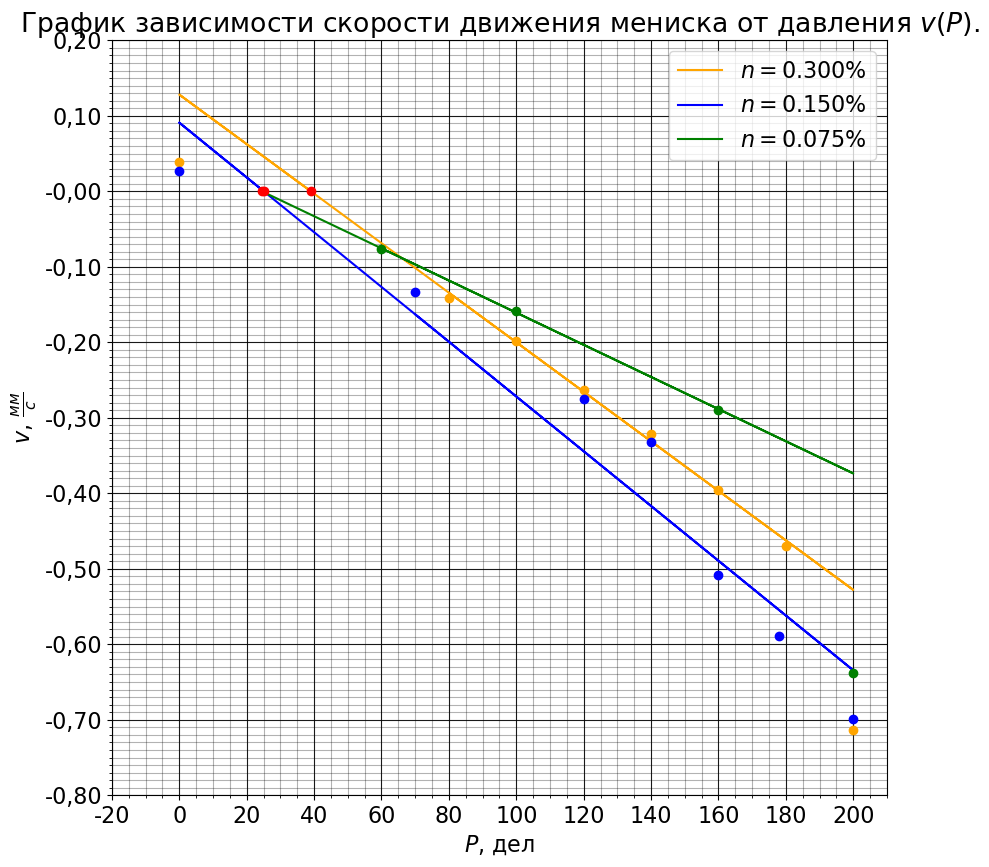

In [19]:
# Загрузка данных
plotTitle       = 'График зависимости скорости движения мениска от давления $v(P)$.'

xLabel          = '$P$, дел'
yLabel          = '$v$, $\\frac{мм}{с}$'

concIndex = 0

yMin            = -0.8001
yMax            = 0.2

xMin            = -20
xMax            = 210.0001

yMinorStep      = 0.01
yMajorStep      = 0.1

xMinorStep      = 5
xMajorStep      = 20

xTickMultiplier = 1
yTickMultiplier = 1

xPrecision      = 0
yPrecision      = 2

colors = ['orange', 'blue', 'green']

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,10), dpi = 100)
axes = fig.add_subplot()

fig.set_facecolor("white")

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

for st in range(0, 3):#len(exps)):
    exp = exps[st]
    
    P = [exp.Posm] + exp.P.tolist()
    
    P = np.array(P)
    
    plt.errorbar(exp.P, exp.v, xerr = sig_P, yerr = exp.sig_v, fmt = 'o', color = colors[st])

    plt.plot(P, Line(P, *exp.popt_v_p), label = '$n = {:.3f}\\%$'.format(n[st] * 100), c = colors[st])
    
    plt.errorbar(exp.Posm, 0, xerr = sig_P, yerr = 0, fmt = 'o', color = 'red')

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда

plt.legend(loc = 'upper right')

# Сетка

plt.grid(b=True, which='major', c = 'black', alpha = 0.9)
plt.grid(b=True, which='minor', c = 'black', alpha = 0.3)

# Вывод

plt.savefig("plots\\graph_v_p.png")

plt.show()

In [12]:
print(Posm_calc[0] / P_conv)
print(Posm[0] / P_conv)
print(4000 / P_conv)

82.31985438452477
39.025406481442815
16.315459407646852


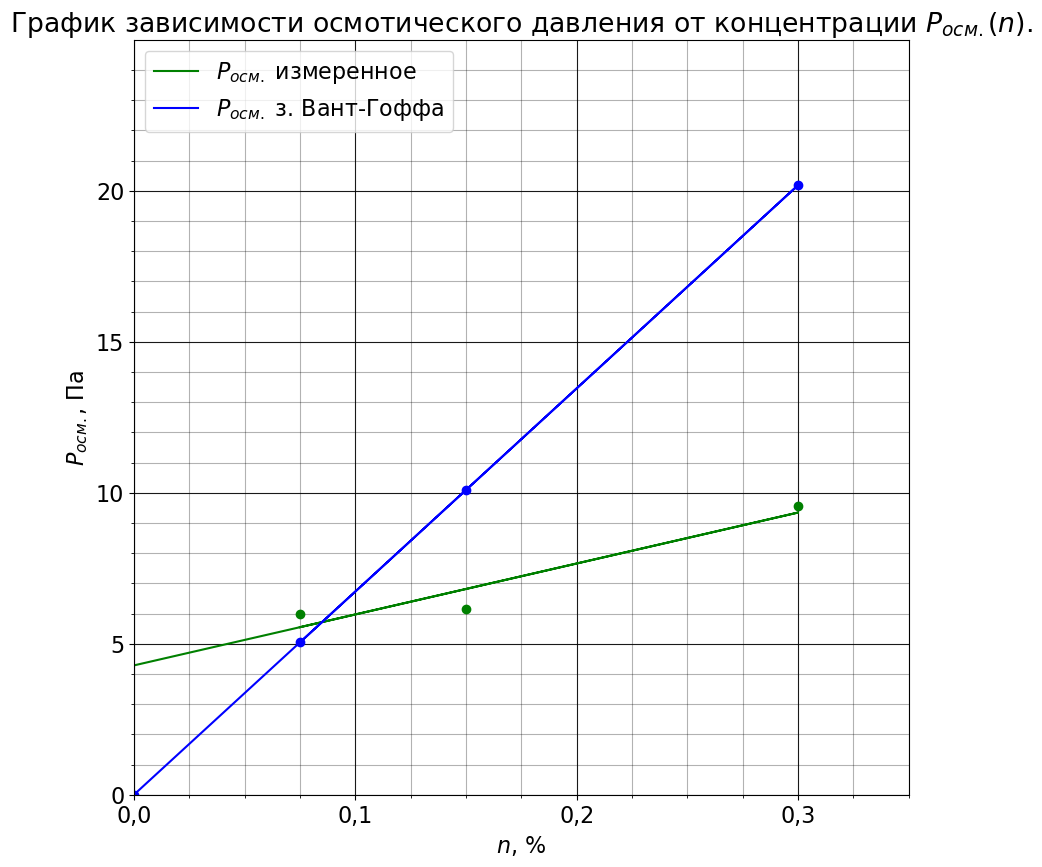

In [13]:
# Загрузка данных
plotTitle       = 'График зависимости осмотического давления от концентрации $P_{осм.}(n)$.'

yLabel          = '$P_{осм.}$, Па'
xLabel          = '$n$, %'

concIndex = 0

yMin            = 0
yMax            = 25000

xMin            = 0
xMax            = 0.3501

yMinorStep      = 1000
yMajorStep      = 5000

xMinorStep      = 0.025
xMajorStep      = 0.1

xTickMultiplier = 1
yTickMultiplier = 0.001

xPrecision      = 1
yPrecision      = 0

colors = ['orange', 'blue', 'green']

# Построение графика.

mpl.rcParams['font.size'] = 16

fig  = plt.figure(figsize = (10,10), dpi = 100)
axes = fig.add_subplot()

# Заголовок

plt.title(plotTitle)
plt.xlabel(xLabel)
plt.ylabel(yLabel)

# Линии

_n = np.array([0] + n100.tolist())

plt.errorbar(n100, Posm, xerr = 0, yerr = Posm_sig, fmt = 'o', color = 'green')

plt.plot(_n, Line(_n, *Posm_popt), label = '$P_{осм.}$ измеренное', c = 'green')

_Posm_calc = np.array([0] + Posm_calc.tolist())

plt.errorbar(_n, _Posm_calc, xerr = 0, yerr = 0, fmt = 'o', color = 'blue')

plt.plot(_n, Line(_n, *Posm_calc_popt), label = '$P_{осм.}$ з. Вант-Гоффа', c = 'blue')

# Оформление масштабных чёрточек

if yMajorStep > 0:
    y_major_ticks = np.arange(yMin, yMax, yMajorStep)
    axes.set_yticks(y_major_ticks)

if yMinorStep > 0:
    y_minor_ticks = np.arange(yMin, yMax, yMinorStep)
    axes.set_yticks(y_minor_ticks, minor = True)

if xMajorStep > 0:
    x_major_ticks = np.arange(xMin, xMax, xMajorStep)
    axes.set_xticks(x_major_ticks)

if xMinorStep > 0:
    x_minor_ticks = np.arange(xMin, xMax, xMinorStep)
    axes.set_xticks(x_minor_ticks, minor = True)

# Пределы графика

plt.xlim([xMin, xMax])
plt.ylim([yMin, yMax])

# Форматирование чёрточек

def xTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * xTickMultiplier, prec = xPrecision).replace('.', ',')

def yTickFormatter(tickVal, position):
    return "{:.{prec}f}".format(tickVal * yTickMultiplier, prec = yPrecision).replace('.', ',')

axes.xaxis.set_major_formatter(ticker.FuncFormatter(xTickFormatter))
axes.yaxis.set_major_formatter(ticker.FuncFormatter(yTickFormatter))

# Легенда

plt.legend(loc = 'upper left')

# Сетка

plt.grid(b=True, which='major', c = 'black', alpha = 0.9)
plt.grid(b=True, which='minor', c = 'black', alpha = 0.3)

# Вывод

plt.savefig("plots\\graph_p_osm_n.png")

plt.show()

## Таблицы

In [30]:
for st in range(0, len(n)):
    
    exp = exps[st]
    
    for st1 in range(0, h_t_count[st]):
        
        CreateVerticalTableHeader('n' + str(n[st] * 100) + 'p' + str(exp.P[st1]) + '.tex',
                                  ['$t_{абс}$, с', '$h$, мм'],
                                  [exp.t[st1].astype(str).tolist(), exp.h[st1].astype(str).tolist()],
                                  None,
                                  [1, 1] + [0] * (len(exp.t[st1]) - 1) + [1],
                                  preheader = #"$n, \\%$ & " + str(n[st] * 100) + " \\\\\n" +\
                                              #"\hline\n" +\
                                              "$P$, дел & {:d} \\\\\n".format(int(exp.P[st1])) +\
                                              "\hline\n"
                                 )

In [47]:
for st in range(0, len(n)):
    exp = exps[st]
    
    a = []
    b = []
    sig_a = []
    sig_b = []
    p = []
    
    for st1 in range(0, h_t_count[st]):
        
        a.append(exp.popt_h_t[st1][0])
        b.append(exp.popt_h_t[st1][1])
        
        sig_a.append(exp.err_h_t[st1][0])
        sig_b.append(exp.err_h_t[st1][1])
        
        p.append(exp.P[st1])
        
    a = NpToStrList(np.array(a), 3)
    b = NpToStrList(np.array(b), 1)
    sig_a = NpToStrList(np.array(sig_a), 3)
    sig_b = NpToStrList(np.array(sig_b), 1)
    p = NpToStrList(np.array(p), 0)
        
    CreateVerticalTableHeader('h_t_fit ver n' + str(n[st] * 100) + '.tex',
                              ['$p$, дел', '$a$, $\\frac{мм}{с}$', '$\\sigma_a$, $\\frac{мм}{с}$', '$b$, мм', '$\\sigma_b$, мм'],
                              [p, a, sig_a, b, sig_b],
                              None,
                              [1, 1] + [0] * (len(p) - 1) + [1])

In [51]:
for st in range(0, len(n)):
    exp = exps[st]
    
    a = []
    b = []
    sig_a = []
    sig_b = []
    p = []
    
    for st1 in range(0, h_t_count[st]):
        
        a.append(exp.popt_h_t[st1][0])
        b.append(exp.popt_h_t[st1][1])
        
        sig_a.append(exp.err_h_t[st1][0])
        sig_b.append(exp.err_h_t[st1][1])
        
        p.append(exp.P[st1])
        
    a = NpToStrList(np.array(a), 3)
    b = NpToStrList(np.array(b), 1)
    sig_a = NpToStrList(np.array(sig_a), 3)
    sig_b = NpToStrList(np.array(sig_b), 1)
    p = NpToStrList(np.array(p), 0)
    
    for i in range(0, len(sig_a)):
        if (sig_a[i] == "000"):
            sig_a[i] = "0.01"
    
    dataRows = [
        ["$P$, дел"] + p,
        ["$v$, $\\frac{мм}{с}$"] + a,
        ["$\\sigma_v$, $\\frac{мм}{с}$"] + sig_a
    ]
        
    CreateHorizontalTable('h_t_fit hor n' + str(n[st] * 100) + '.tex', 
                          dataRows,
                          None,
                          [1, 1, 1, 1])

In [32]:
help(CreateHorizontalTable)

Help on function CreateHorizontalTable in module __main__:

CreateHorizontalTable(fileName, dataRows, columnGrid=None, rowGrid=None, preheader=None)
    Создаёт горизонтальную Latex-таблицу.



In [22]:
a = []
b = []
sig_a = []
sig_b = []
_n = []

for st in range(0, len(n)):
    exp = exps[st]
    
    a.append(exp.popt_v_p[0])
    b.append(exp.popt_v_p[1])
    sig_a.append(exp.err_v_p[0])
    sig_b.append(exp.err_v_p[1])
    _n.append(n[st] * 100)

a = NpToStrList(np.array(a), 4)
b = NpToStrList(np.array(b), 4)
sig_a = NpToStrList(np.array(sig_a), 4)
sig_b = NpToStrList(np.array(sig_b), 4)
_n = NpToStrList(np.array(_n), 2)

CreateVerticalTableHeader('v_p_fit.tex',
                          ['$n$, \\%', '$a$, $\\frac{мм}{с \\cdot дел}$', '$\\sigma_a$, $\\frac{мм}{с \\cdot дел}$',
                           '$b$, $\\frac{мм}{с}$', '$\\sigma_b$, $\\frac{мм}{с}$'],
                          [_n, a, sig_a, b, sig_b],
                          None,
                          [1, 1] + [0] * (len(_n) - 1) + [1])

In [23]:
a = NpToStrList(np.array([Posm_popt[0]]), 4)
b = NpToStrList(np.array([Posm_popt[1]]), 4)
sig_a = NpToStrList(np.array([Posm_err[0]]), 4)
sig_b = NpToStrList(np.array([Posm_err[1]]), 4)

CreateVerticalTableHeader('p_n_fit.tex',
                          ['$a$, $\\frac{Па}{\\%}$', '$\\sigma_a$, $\\frac{Па}{\\%}$',
                           '$b$, Па', '$\\sigma_b$, Па'],
                          [a, sig_a, b, sig_b],
                          None,
                          [1, 1] + [0] * (len(a) - 1) + [1])